# ECE 9039 Machine Learning Project

In [ ]:
import os
import pickle
import PIL
import matplotlib.pyplot as plt
import IPython.display as display
import time
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras.applications import vgg19

Set Random Seeds

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
result_prefix = "generated-"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the base picture.
width, height = 256, 256

Helper functions

In [ ]:
def preprocess_image(img):

    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):

    x = x.reshape((256, 256, 3))

    # Remove zero-center by mean pixel, mean pixel values provided by ImageNet
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

Define Loss functions

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = 256 * 256
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    loss = tf.image.total_variation(x)
    return loss

Feature Extractor

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Data Loading

Jpg files are reorganized into a txt file to allow easy uploading to colab

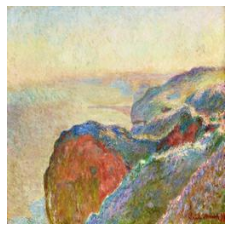

(300, 256, 256, 3)

In [ ]:
with open('monet.txt','rb') as read_file:
  monet_img_list = pickle.load(read_file)

plt.imshow(monet_img_list[0])
plt.axis('off')
plt.show()

monet_array = np.array(monet_img_list)
monet_array.shape

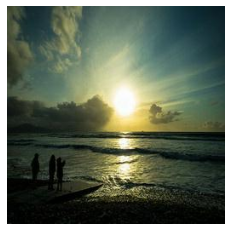

(300, 256, 256, 3)

In [ ]:
with open('photo300.txt','rb') as read_file:
  photo_list = pickle.load(read_file)

plt.imshow(photo_list[0])
plt.axis('off')
plt.show()

photo_array = np.array(photo_list)
photo_array.shape

In [ ]:
from sklearn.utils import shuffle

photo_array = shuffle(photo_array, random_state = 42)
monet_array = shuffle(monet_array, random_state = 42)

In [ ]:
!mkdir neural-translated

Image translation

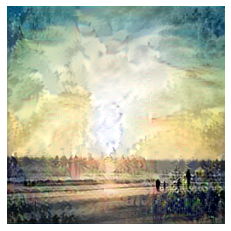

Saving generated image 119
Total time: 2335.2


In [ ]:
num_images = 120
start = time.time()

prediction_list = []

for image in range(num_images):

  optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
  )

  base_image = preprocess_image(photo_array[image])
  style_reference_image = preprocess_image(monet_array[image])
  combination_image = tf.Variable(preprocess_image(photo_array[image]))

  iterations = 1000
  for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
      print("Iteration %d: loss=%.2f" % (i, loss))

  display.clear_output(wait=True)
  img = deprocess_image(combination_image.numpy())

  prediction_list.append(img)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print('Saving generated image ' + str(image))
  fname = './neural-translated/' + result_prefix + str(image)+'.png'
  keras.preprocessing.image.save_img(fname, img)

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
!zip -r neural-translated.zip neural-translated/

  adding: neural-translated/ (stored 0%)
  adding: neural-translated/generated-116.png (deflated 0%)
  adding: neural-translated/generated-62.png (deflated 0%)
  adding: neural-translated/generated-113.png (deflated 0%)
  adding: neural-translated/generated-38.png (deflated 0%)
  adding: neural-translated/generated-13.png (deflated 0%)
  adding: neural-translated/generated-83.png (deflated 0%)
  adding: neural-translated/generated-17.png (deflated 0%)
  adding: neural-translated/generated-64.png (deflated 0%)
  adding: neural-translated/generated-42.png (deflated 0%)
  adding: neural-translated/generated-104.png (deflated 0%)
  adding: neural-translated/generated-6.png (deflated 0%)
  adding: neural-translated/generated-16.png (deflated 0%)
  adding: neural-translated/generated-15.png (deflated 0%)
  adding: neural-translated/generated-108.png (deflated 0%)
  adding: neural-translated/generated-90.png (deflated 0%)
  adding: neural-translated/generated-51.png (deflated 0%)
  adding: ne

Visualization

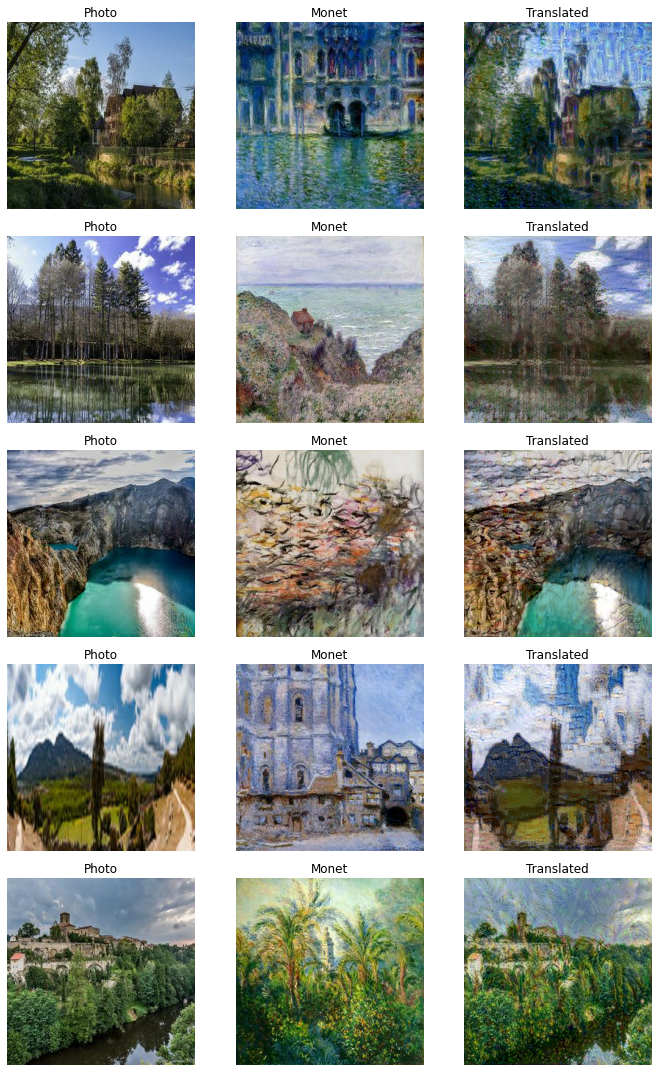

In [ ]:
_, ax = plt.subplots(5, 3, figsize=(10, 15))
for i in range(5):
  content = photo_array[i]
  style = monet_array[i]
  translated = keras.preprocessing.image.load_img('./neural-translated/generated-'+str(i)+'.png')

  ax[i, 0].imshow(content)
  ax[i, 1].imshow(style)
  ax[i, 2].imshow(translated)
  ax[i, 0].set_title('Photo')
  ax[i, 1].set_title('Monet')
  ax[i, 2].set_title('Translated')
  ax[i, 0].axis('off')
  ax[i, 1].axis('off')
  ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

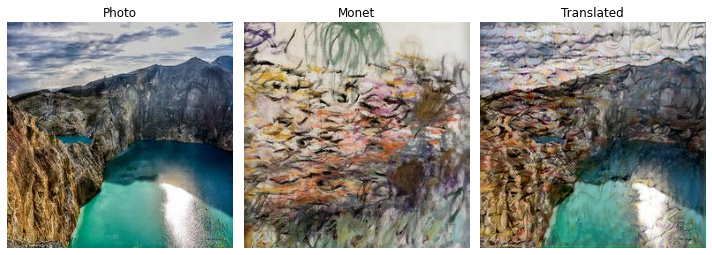

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(10, 15))

content = photo_array[2]
style = monet_array[2]
translated = keras.preprocessing.image.load_img('./neural-translated/generated-'+str(2)+'.png')

ax[0].imshow(content)
ax[1].imshow(style)
ax[2].imshow(translated)
ax[0].set_title('Photo')
ax[1].set_title('Monet')
ax[2].set_title('Translated')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

plt.tight_layout()
plt.show()

Inception Score

In [ ]:
from math import floor
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
 
# assumes images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# convert from uint8 to float32
	processed = images.astype('float32')
	# pre-process raw images for inception v3 model
	processed = preprocess_input(processed)
	# predict class probabilities for images
	yhat = model.predict(processed)
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve p(y|x)
		ix_start, ix_end = i * n_part, i * n_part + n_part
		p_yx = yhat[ix_start:ix_end]
		# calculate p(y)
		p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = np.mean(scores), np.std(scores)
	return is_avg, is_std

In [ ]:
resized_prediction_list = []
for prediction in (prediction_list):

    prediction_resized = tf.image.resize(prediction, [299, 299], method=tf.image.ResizeMethod.BILINEAR)
    resized_prediction_list.append(prediction_resized)

resized_prediction_list = np.array(resized_prediction_list)
print(resized_prediction_list.shape)

# calculate inception score
is_avg, is_std = calculate_inception_score(resized_prediction_list)

inception_score = pd.DataFrame(columns=['is_avg', 'is_std'])
inception_score = inception_score.append({'is_avg':is_avg, 'is_std':is_std}, ignore_index=True)
inception_score

(120, 299, 299, 3)
96116736/96112376 [==============================] - 1s 0us/step


,is_avg,is_std
0,3.37993,0.386


Frechet Inception Distance

In [ ]:
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
monet_list = []
for image in range(num_images):
  monet_list.append(monet_array[image])

monet_list = np.array(monet_list)
print(monet_list.shape)

(120, 256, 256, 3)


In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# convert integer to floating point values
monet_list = monet_list.astype('float32')

# resize images
resized_monet_list = []
for img in (monet_list):

    img_resized = tf.image.resize(img, [299, 299], method=tf.image.ResizeMethod.BILINEAR)
    resized_monet_list.append(img_resized)

resized_monet_list = np.array(resized_monet_list)
print(resized_monet_list.shape)

# pre-process images
images1 = preprocess_input(resized_monet_list)
images2 = preprocess_input(resized_prediction_list)

# fid between images1 and images1
fid_same = calculate_fid(model, images1, images1)
# fid between images1 and images2
fid_diff = calculate_fid(model, images1, images2)

fid_score = pd.DataFrame(columns=['FID_same', 'FID_diff'])
fid_score = fid_score.append({'FID_same': fid_same, 'FID_diff':fid_diff}, ignore_index=True)
fid_score

87916544/87910968 [==============================] - 1s 0us/step
(120, 299, 299, 3)


,FID_same,FID_diff
0,-0.000053,165.860168
